In [1]:
# Install optuna if not already installed
!pip install optuna

# Install catboost if not already installed
!pip install catboost

import pandas as pd
import optuna
from sklearn.model_selection import GroupKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from catboost import CatBoostClassifier

# Step 1: Load dataset
df = pd.read_csv('water_potability_final.csv')

# Step 2: Separate features and target
X = df.drop('Potability', axis=1)
y = df['Potability']

# Artificial groups for GroupKFold
groups = np.arange(len(X)) % 5

# Step 3: Train-test split
X_train, X_test, y_train, y_test, groups_train, groups_test = train_test_split(
    X, y, groups, test_size=0.2, random_state=42
)

# Step 4: Define Optuna objective function
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 800),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.0),
        "verbose": 0,
        "random_seed": 42,
        "thread_count": -1
    }

    model = CatBoostClassifier(**params)
    gkf = GroupKFold(n_splits=5)
    scores = cross_val_score(
        model, X_train, y_train,
        cv=gkf.split(X_train, y_train, groups_train),
        scoring='accuracy'
    )
    return scores.mean()

# Step 5: Run Optuna optimization (max 30 trials or 30 minutes)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800, show_progress_bar=True)

# Step 6: Train CatBoost model with best parameters
best_params = study.best_params
cat_best = CatBoostClassifier(**best_params, verbose=0, random_seed=42)
cat_best.fit(X_train, y_train)

# Step 7: Evaluate model
y_pred = cat_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 8: Display results
results = pd.DataFrame([{
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1
}])

print("\n Water Potability Model Performance (CatBoost):\n", results)
print("\n Best Parameters Found by Optuna:\n", best_params)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00


[I 2025-11-16 07:48:25,499] A new study created in memory with name: no-name-2ea2d3ca-631a-4b51-aba0-2ccbcbe7a374


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-16 07:48:36,458] Trial 0 finished with value: 0.7973887319442754 and parameters: {'iterations': 766, 'depth': 5, 'learning_rate': 0.07549448967358686, 'l2_leaf_reg': 6.143109417125296, 'bagging_temperature': 0.11287433638470767, 'border_count': 254, 'random_strength': 0.6545977890286492}. Best is trial 0 with value: 0.7973887319442754.
[I 2025-11-16 07:48:43,786] Trial 1 finished with value: 0.798462698439794 and parameters: {'iterations': 716, 'depth': 4, 'learning_rate': 0.14913567580733975, 'l2_leaf_reg': 8.99163125308968, 'bagging_temperature': 0.41145628783595145, 'border_count': 145, 'random_strength': 0.8139436030614184}. Best is trial 1 with value: 0.798462698439794.
[I 2025-11-16 07:48:47,354] Trial 2 finished with value: 0.7965097039162446 and parameters: {'iterations': 317, 'depth': 6, 'learning_rate': 0.05525932303997138, 'l2_leaf_reg': 8.208373548745888, 'bagging_temperature': 0.5004361112876059, 'border_count': 97, 'random_strength': 1.4411456417218904}. Best i

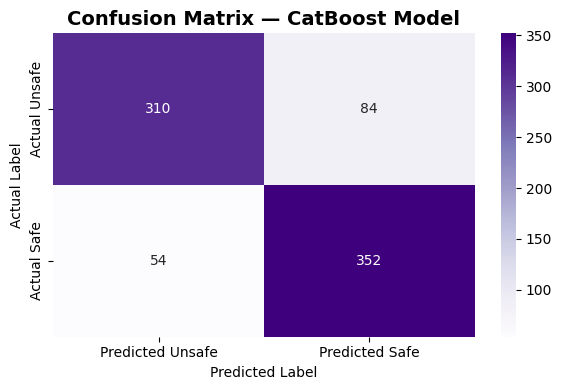

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Predicted Unsafe','Predicted Safe'],
            yticklabels=['Actual Unsafe','Actual Safe'])

plt.title('Confusion Matrix — CatBoost Model', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()
